# Summary of previous notebooks

In [1]:
import os
import glob
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap as LSCm
from scipy.interpolate import griddata
from scipy.signal import savgol_filter
from scipy import integrate
from NesrHydrusAnalyst import *

In [2]:
def draw_full_contour(data_frame,variable=0, time_step=180, grid= 0.5, 
                      crosses=35., tol=10., section= 'x', levels=None,
                      plot_title="ElNesr cross sectional contour map",
                      return_arrays=True, x_step=None, z_step=None,
                      mirror_x=False, mirror_z=False, is2d=False, 
                      output_the_contour=True, is_axisymmetric=False,
                      return_figure_object=False, fig_size=(18, 7)):
    
    '''
    Either (1) set the return_arrays to True and use on right 
                hand side of equal sign, 
    OR     (2) set the return_arrays to False and use the function as is.
    Examples:
    (1)
       arrays = draw_full_contour(data_frame,variable, time_step, grid, 
                                   crosses, tol, section)
       It will draws the chart AND sets arrays=X, Z, M, levels
    (2)
       draw_full_contour(data_frame,variable, time_step, grid, crosses, 
                           tol, section, return_arrays=False)    
    '''
#     print('is2d=', is2d)
    X, Z, M, x_vals, z_vals = get_grid_values(data_frame, variable, 
                                              time_step, grid, crosses, 
                                              tol, section, is2d=is2d)
    # print(x_vals.shape, z_vals.shape, X.shape, Z.shape, M.shape)
    if levels is None:
        levels = get_legend_range(np.nanmin(M),np.nanmax(M))#np.arange(0.15, 0.42, 0.03)

    mn, mx = np.nanmin(M),np.nanmax(M)
    # print (mx,mn, mx-mn)
    if mx - mn < 0.000000001:
        print('For the requested contour map of {}'.format(plot_title), end='. ')
        print ("The map has one value only ({}), no contour map will be drawn.".
               format(mn))
        can_draw_figure=False
    else:
        can_draw_figure=True

    if not output_the_contour and not return_figure_object:
        fig = None
    else:
        if can_draw_figure:
            fig = draw_contour(X, Z, M, levels, plot_title, x_step, z_step,
                             mirror_x, mirror_z, return_figure_object, fig_size=fig_size);
        else:
            fig = None

#     exit()
    if return_arrays:
        if output_the_contour:
            if return_figure_object:
                return X, Z, M, levels, fig
            else: # return_figure_object=False
                display(fig)
                # fig.show()
                return X, Z, M, levels
        else:  #output_the_contour=False
            if return_figure_object:
                return X, Z, M, levels, fig
            else: # return_figure_object=False
                return X, Z, M, levels
    else:  #return_arrays=False
        if output_the_contour:
            if return_figure_object:
                return fig
            else: # return_figure_object=False
                display(fig)
                # fig.show()
        else:  #output_the_contour=False
            if return_figure_object:
                return fig
            
def draw_contour(X, Z, M, levels=None,
                 plot_title="ElNesr cross sectional contour map",
                 x_step=10., z_step=25., mirror_x=False, mirror_z=False,
                 return_figure_object=False, fig_size=(18, 7)):
    '''

    '''
    fig = plt.figure(num=None, figsize=fig_size, dpi=80,
                     facecolor='w', edgecolor='k')
    origin = 'lower'

    if levels is None:
        #         print(M.min(), M.max())
        try:
            #             levels = get_legend_range(M.min(), M.max())#np.arange(0.15, 0.42, 0.03)
            # np.arange(0.15, 0.42, 0.03)
            levels = get_legend_range(np.nanmin(M), np.nanmax(M))
        except:
            levels = get_legend_range(-.15, 0.15)

    CS_lines = plt.contour(X, Z, M, levels, cmap=plt.cm.Accent_r,
                           linewidths=(0.9,), origin=origin, extend='both')

    CS_fill = plt.contourf(X, Z, M, levels, cmap=plt.cm.YlGn,
                           origin=origin, extend='both')

    CS_fill.cmap.set_under('oldlace')
    CS_fill.cmap.set_over('darkslategrey')
    plt.title(plot_title)
    plt.ylabel("Depth (cm)")
    cols = plt.cm.Accent_r(CS_lines.norm(CS_lines.levels))
    # plt.clabel(CS_lines, linewidths=4, fmt='%2.2f', fontsize='x-large',
    plt.clabel(CS_lines, fmt='%2.2f', fontsize='x-large',
               colors=cols, inline=True, inline_spacing=10)
    plt.colorbar(CS_fill)

    def adjust_max_and_min(_min, _max, _step):
        nn, xx, ss = _min, _max, _step
        if xx <= 0.:
            nn, xx = xx, nn
            if ss > 0:
                ss = -ss
        return nn, xx, ss

    def adjust_axis_labels(_min, _max, _step):
        nn, xx, ss = adjust_max_and_min(_min, _max, _step)

        x_list = np.arange(nn, xx, ss)
        if abs(x_list[-1]-xx) > 3:  # The last number is far enough from
                                 # the maximum element
            x_list = np.hstack([x_list, xx])
        else:  # The last number is too close to the maximum element
            x_list = np.hstack([x_list[:-1], xx])
        return x_list

    def adjust_mirrored_labels(_min, _max, _step):
        #         print(_min, _max, _step)
        nn, xx, ss = adjust_max_and_min(_min, _max, _step)
        x_mid = (xx-nn)/2.

        if x_mid < 0:
            right_list = adjust_axis_labels(min(x_mid, xx), max(x_mid, xx), ss)
            left_list = right_list - x_mid
            right_list = x_mid - right_list

            left_list.sort()

            label_list = np.hstack([left_list[:-1], right_list])

            real_list = x_mid-label_list
            label_list = label_list[::-1]
            return real_list, label_list
        elif x_mid > 0:
            right_list = adjust_axis_labels(x_mid, xx, ss)
            left_list = 2 * x_mid - right_list
            left_list.sort()
            real_list = np.hstack([left_list[:-1], right_list])
            label_list = real_list - x_mid
            label_list = tuple(['{:3.1f}'.format(x) for x in label_list])
            return real_list, label_list
        else:
            real_list, label_list = None, None
            return real_list, label_list


    if mirror_x:
        if x_step is not None:
            ticks, labels = adjust_mirrored_labels(X.min(), X.max(), x_step)
            plt.xticks(ticks, labels)
    else:  # No Mirroring
        if x_step is not None:
            plt.xticks(adjust_axis_labels(X.min(), X.max(), x_step))

    if mirror_z:
        if z_step is not None:
            ticks, labels = adjust_mirrored_labels(Z.min(), Z.max(), z_step)
            plt.yticks(ticks, labels)
    else:  # No Mirroring
        if z_step is not None:
            plt.yticks(adjust_axis_labels(Z.min(), Z.max(), z_step))
    ax = plt.gca()
    ax.grid(True, zorder=0)
    if return_figure_object:
        return fig
    else:
        plt.show()
        
def get_fig_shape(data_frame, 
                  selected_dim='y',
                  max_height=8,
                  extra_width=1):
    '''
    Returns a proportunal tuple contains the width and the height for a specific data_frame
        If the data_frame is a 3D frame, then specify the slicing dimension as selected_dim, 
        with default value as 'y', which returns a xz 2D dataframe.
        the max_height is a limiting factor for the figure's shape, the width will vary, 
        but the height will be as specified hers, with default value =8.
        the width reflects the figure and the legend, that's why we add and extra_width of 1 
        in most cases, else if specified otherwise.
    '''
    dims = get_full_dimensions(data_frame)
    for dim, vals in dims.items():
        mn, mx = vals
        length = mx-mn
        dims[dim] = length
    sels = {d: dims[d] for d in dims.keys() if d != selected_dim}
    fig_shape = np.array(list(sels.values()))  # [::-1]
    fig_shape = np.ceil(fig_shape*max_height/fig_shape[1])
    fig_shape[0] += extra_width
    return tuple(fig_shape)

## Specific codes

### From Notebook 1

In [ ]:
src = '../Datasets/sample3d'
data_frame= read_hydrus_data(folder=src, save_to_csv=False)
v=0
X, Z, M, x_vals, z_vals = get_grid_values(data_frame,variable=v)

In [4]:
print('x_vals{}, z_vals{}, X{}, Z{}, M{}'.format(x_vals.shape, z_vals.shape,
                                                 X.shape, Z.shape, M.shape))
display(
    get_available_timesteps(data_frame), get_full_dimensions(data_frame),
    get_legend_range(M.min(), M.max()), get_fig_shape(data_frame, 'y'),
    get_fig_shape(data_frame, 'x'), get_legend_range(M.min(), M.max()))

x_vals(201,), z_vals(251,), X(251, 201), Z(251, 201), M(251, 201)


[0, 15, 60, 120, 180, 360, 720, 1440]

{'x': (0.0, 70.0), 'y': (0.0, 100.0), 'z': (-125.0, 0.0)}

array([0.230, 0.240, 0.250, 0.260, 0.270, 0.280, 0.290, 0.300, 0.310,
       0.320, 0.330, 0.340, 0.350])

(6.0, 8.0)

(8.0, 8.0)

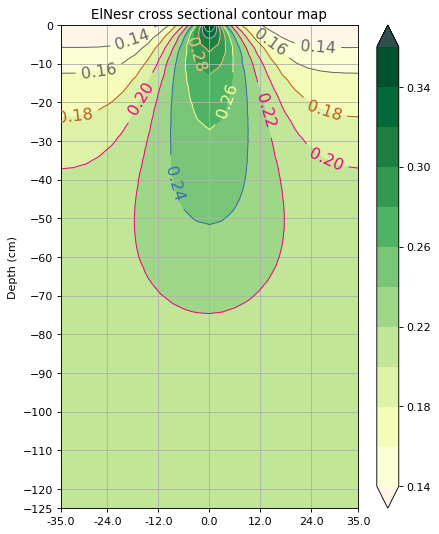

None

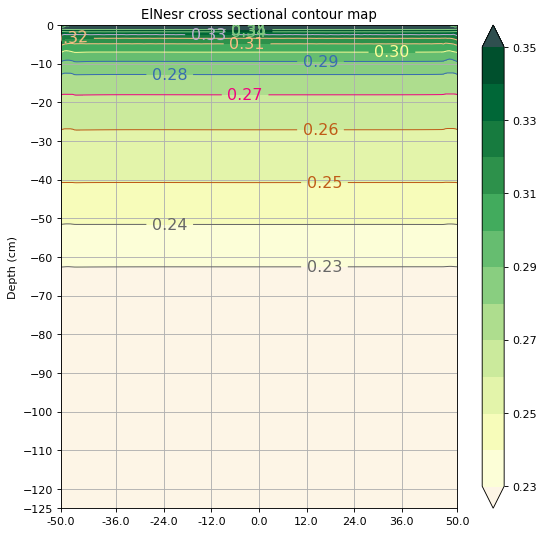

None

,Sand Ditch simulation
SimulTime_s,209.750
L_Unit,1.000
T_Unit,1.000
Category,3.000
MaxIt,10.000
...,...
hMean120,-10.306
hMean180,-10.344
hMean360,-11.299
hMean720,-13.464


In [5]:
# testing draw_full_contour function
# data_frame_test = read_hydrus_data(save_to_csv=False)
variable   = 0 # Theta
time_step  = 180
grid       = 0.5 # cm
crosses    = 50.  #cm0)]
tol        = 10.
section    ='y'

# Either (1) set the return_arrays to True and use on right hand side of equal sign, 
# OR     (2) set the return_arrays to False and use the function as is.

# (1)
# arrays = draw_full_contour(data_frame_test,variable, time_step, 
#                            grid, crosses, tol, section)
# (2)
# draw_full_contour(data_frame_test,variable, time_step, 
_=draw_full_contour(data_frame,variable, time_step, 
                  grid, crosses, tol, section, 
                  return_arrays=False, 
                  x_step=12, z_step=10, 
                  mirror_x=True, mirror_z=False, 
                  fig_size=get_fig_shape(data_frame,section));
section = 'x'
crosses    = 35.  #cm0)]
_=draw_full_contour(data_frame, variable, time_step,
                  grid, crosses, tol, section,
                  return_arrays=False,
                  x_step=12, z_step=10,
                  mirror_x=True, mirror_z=False,
                  fig_size=get_fig_shape(data_frame, section))


# Get other data from 3D simulation
get_one_line_df(src, simulation_name="Sand Ditch simulation", dims='3d').T

### From Notebook 3

In [6]:
src = '../Datasets/H3D2_SandDitch0011'
df = read_hydrus_data(folder=src, save_to_csv=False, read_velocities=True)
df.sample(3)

,n,x,y,z,Th_T0,Th_T5,Th_T15,Th_T30,Th_T60,Th_T120,...,V3_T240,V1_T500,V2_T500,V3_T500,V1_T720,V2_T720,V3_T720,V1_T1440,V2_T1440,V3_T1440
5057,5057,10.0515,18.25,18.1907,0.2,0.209854,0.216460,0.220735,0.386339,0.358943,...,-0.000589,-0.000053,-1.370700e-05,-0.000218,-0.000052,-5.792780e-06,-0.000131,-0.000045,-6.856810e-07,-0.000031
4981,4981,13.0515,9.25,18.1907,0.2,0.200184,0.201054,0.217476,0.353041,0.346342,...,-0.000660,-0.000073,-6.708300e-08,-0.000242,-0.000066,-3.979620e-07,-0.000137,-0.000045,-3.751810e-07,-0.000030
52,52,25.0136,0.00,21.0163,0.1,0.093835,0.348347,0.396352,0.430000,0.193774,...,-0.000740,-0.000331,-8.140150e-06,-0.000137,-0.000158,-3.634360e-06,-0.000059,-0.000052,-8.089020e-07,-0.000013


In [10]:
get_full_simulation_info(df)

 For the entire simulation
Time steps : [0, 5, 15, 30, 60, 120, 180, 240, 500, 720, 1440] 
Dimensions : {'x': (-0.839105, 49.9601), 'y': (0.0, 20.0), 'z': (0.0, 22.9811)} 
Matrix dims: x_vals(41,), z_vals(46,), X(46, 41), Z(46, 41), M(46, 41)


 For the variables

For the variable Th:
Legend range:  [0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37]

For the variable H:
Legend range:  [-120.0, -110.0, -100.0, -90.0, -80.0, -70.0, -60.0, -50.0, -40.0, -30.0, -20.0, -10.0]

For the variable V1:
Legend range:  [-0.002, 0.0, 0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018]

For the variable V2:
Legend range:  [-0.00016, -0.00012, -8e-05, -4e-05, -0.0, 4e-05, 8e-05, 0.00012, 0.00016, 0.0002]

For the variable V3:
Legend range:  [-0.0009, -0.0006, -0.0003, 0.0, 0.0003, 0.0006, 0.0009, 0.0012, 0.0015, 0.0018, 0.0021, 0.0024]


"For variable 'Th', the simulation's crosssection at '15.0 cm' of 'y' direction is:"

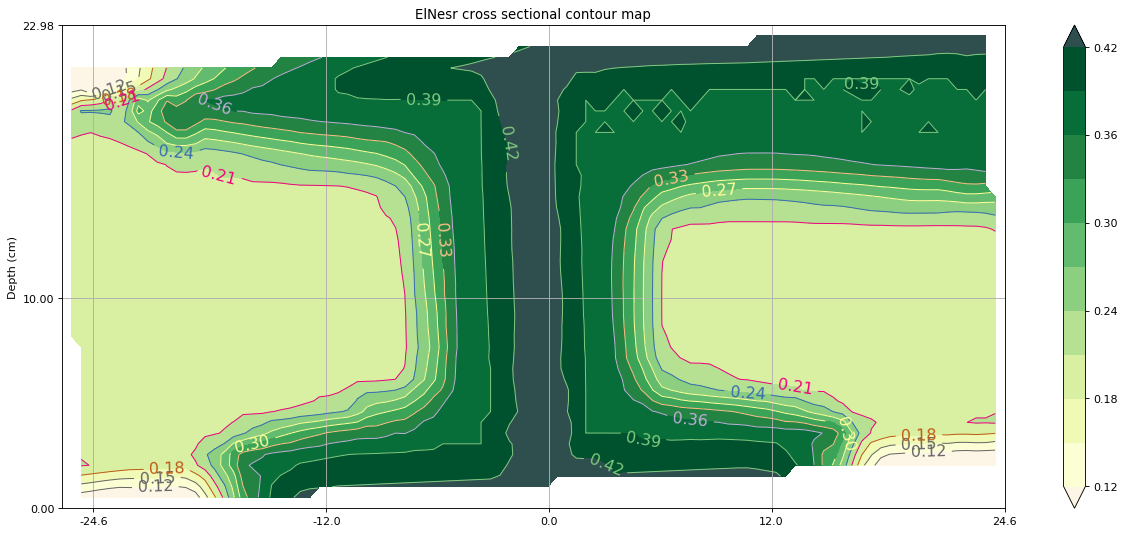

None

"For variable 'H', the simulation's crosssection at '15.0 cm' of 'y' direction is:"

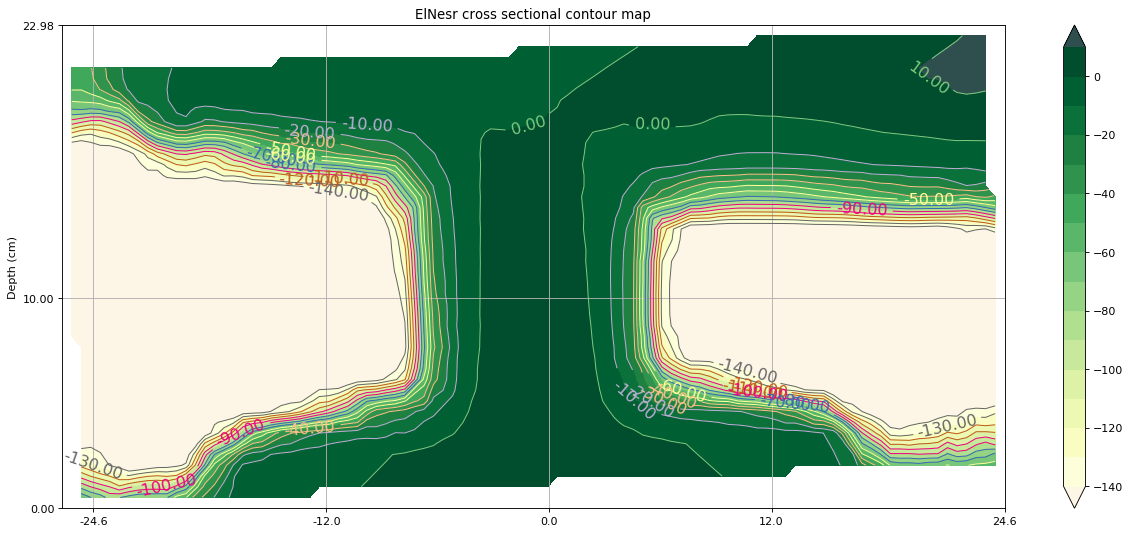

None

"For variable 'V1', the simulation's crosssection at '15.0 cm' of 'y' direction is:"

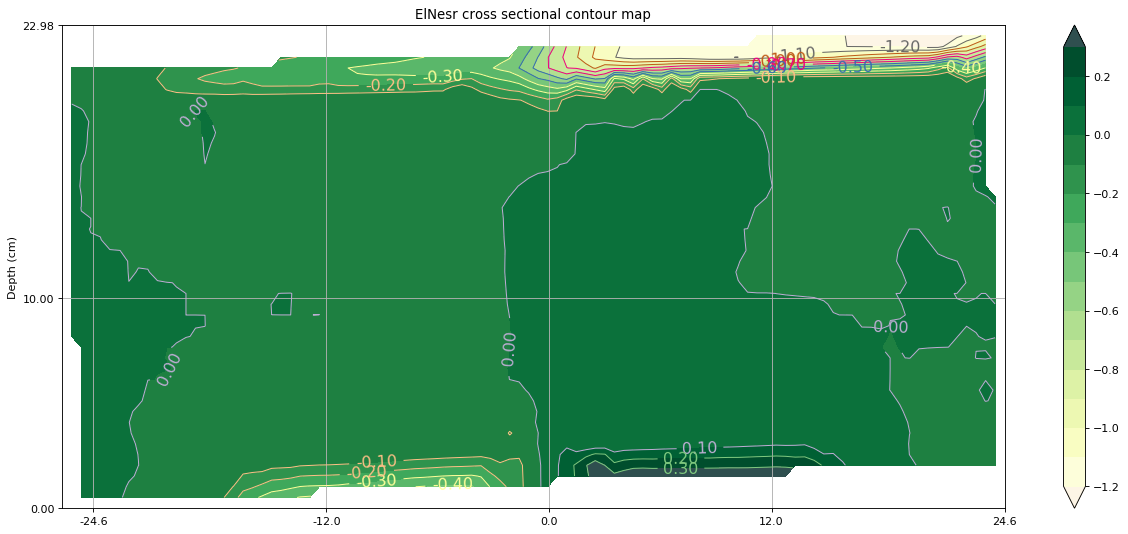

None

"For variable 'V2', the simulation's crosssection at '15.0 cm' of 'y' direction is:"

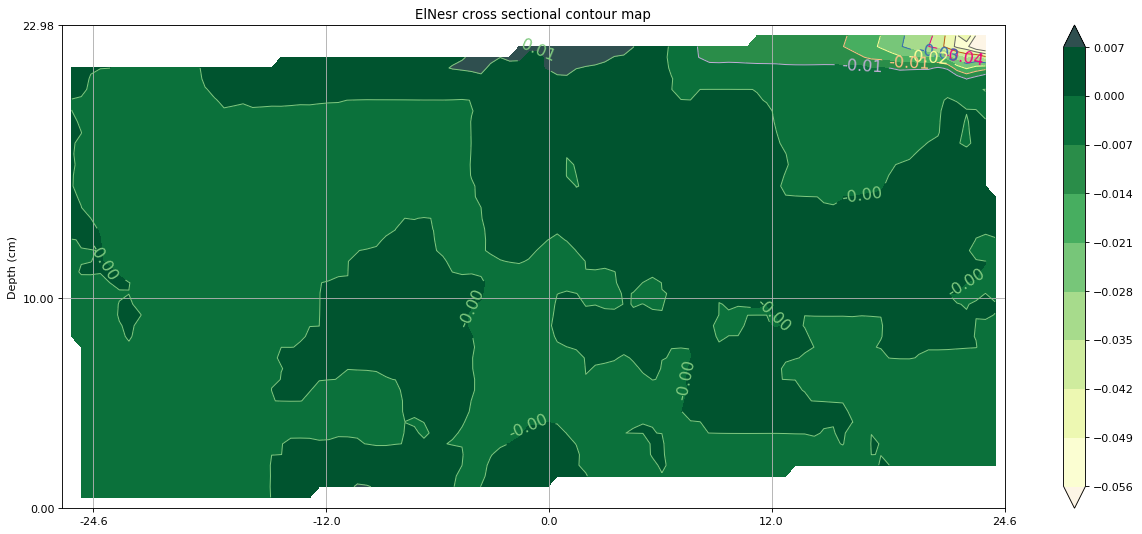

None

"For variable 'V3', the simulation's crosssection at '15.0 cm' of 'y' direction is:"

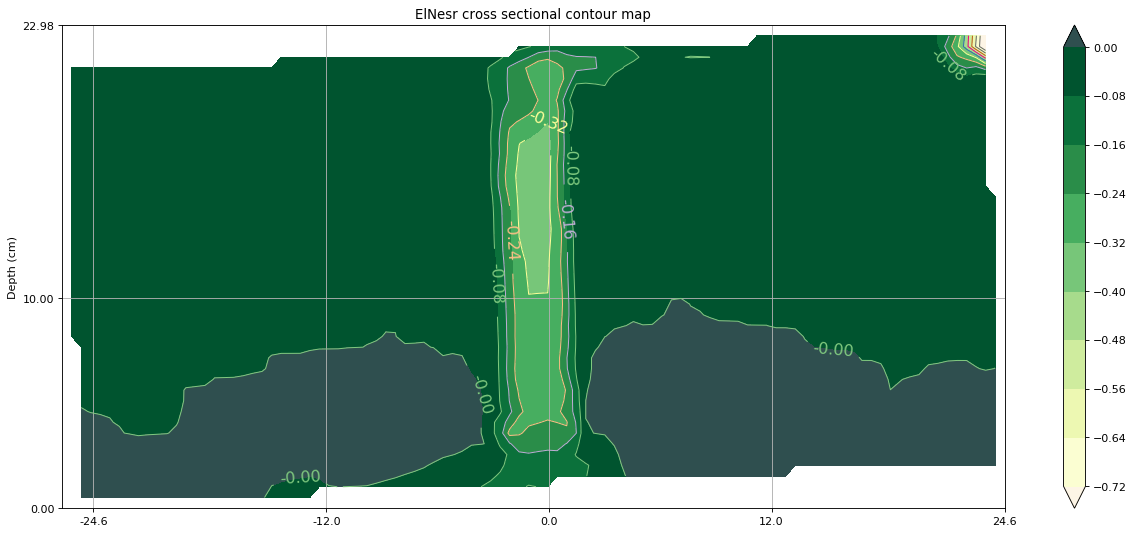

None

"For variable 'Th', the simulation's crosssection at '15.0 cm' of 'x' direction is:"

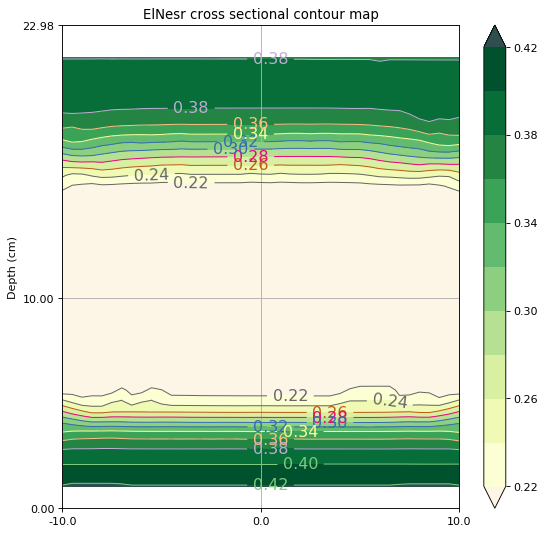

None

"For variable 'H', the simulation's crosssection at '15.0 cm' of 'x' direction is:"

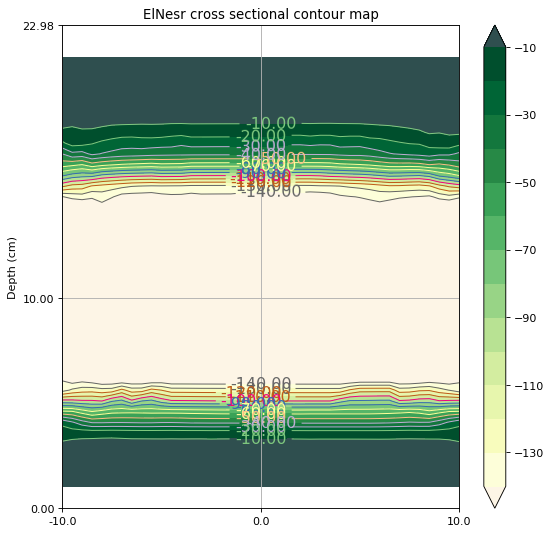

None

"For variable 'V1', the simulation's crosssection at '15.0 cm' of 'x' direction is:"

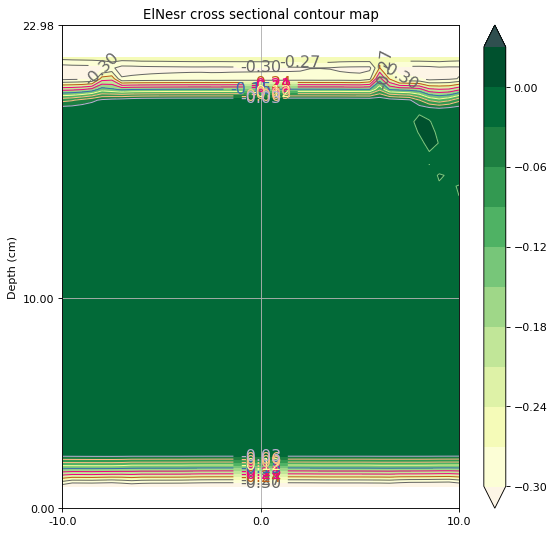

None

"For variable 'V2', the simulation's crosssection at '15.0 cm' of 'x' direction is:"

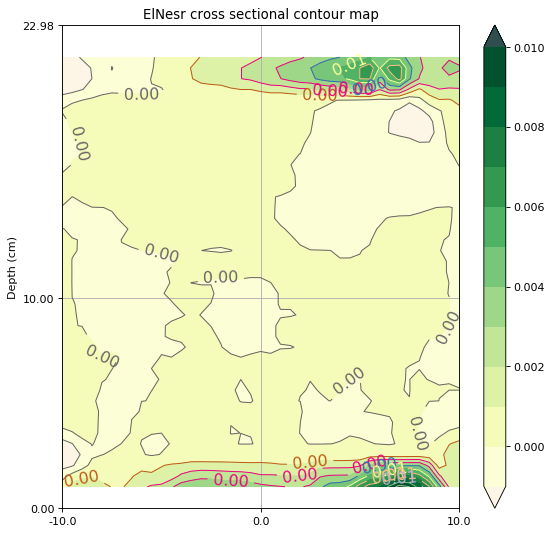

None

"For variable 'V3', the simulation's crosssection at '15.0 cm' of 'x' direction is:"

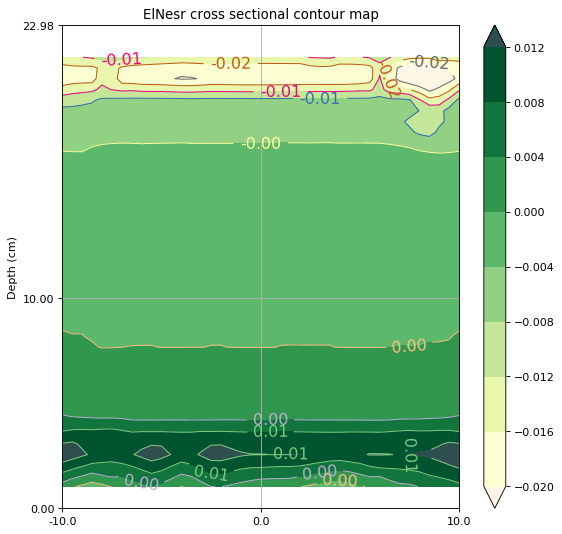

None

"For variable 'Th', the simulation's crosssection at '15.0 cm' of 'z' direction is:"

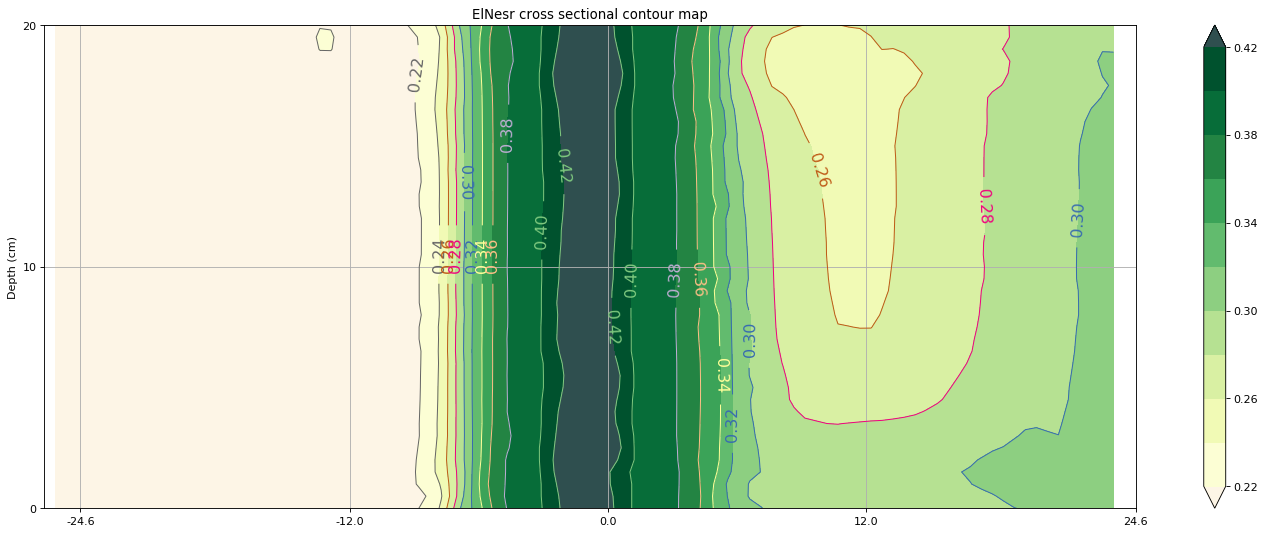

None

"For variable 'H', the simulation's crosssection at '15.0 cm' of 'z' direction is:"

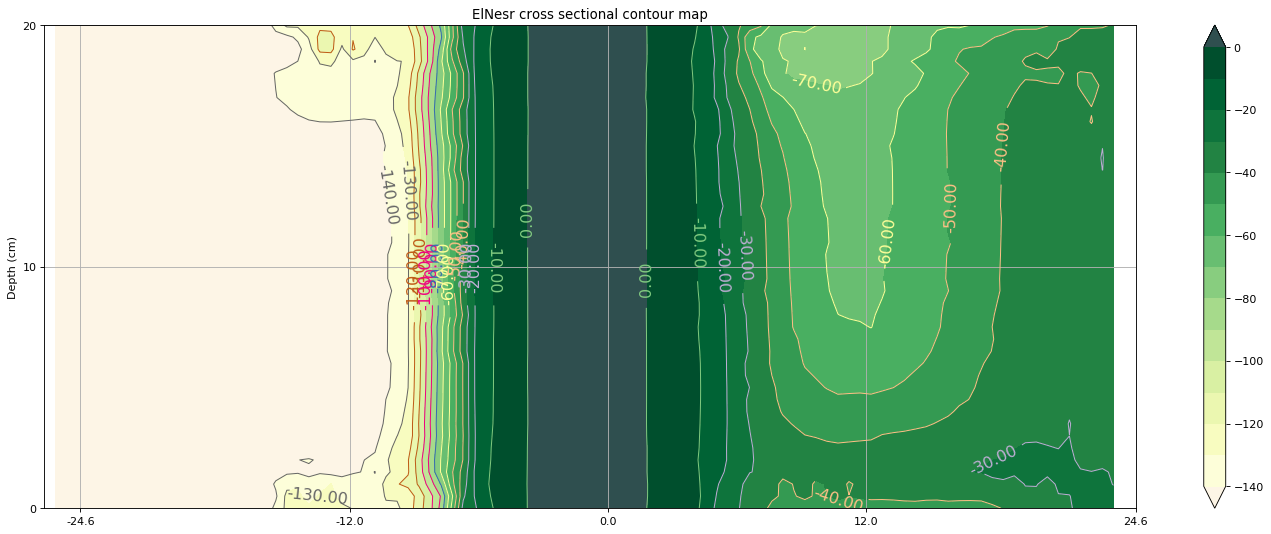

None

"For variable 'V1', the simulation's crosssection at '15.0 cm' of 'z' direction is:"

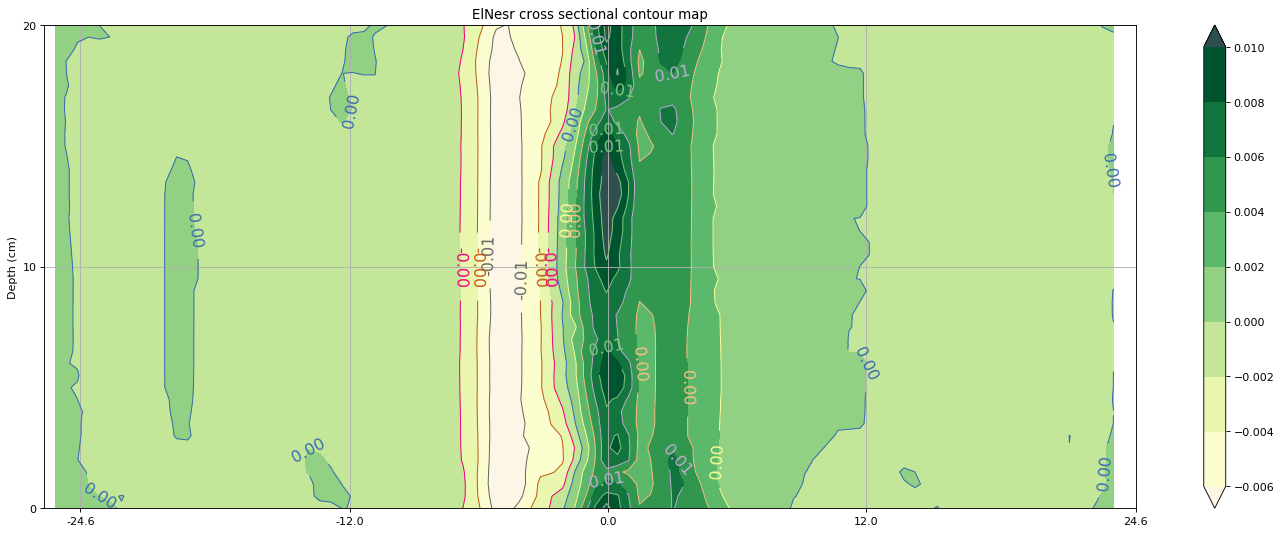

None

"For variable 'V2', the simulation's crosssection at '15.0 cm' of 'z' direction is:"

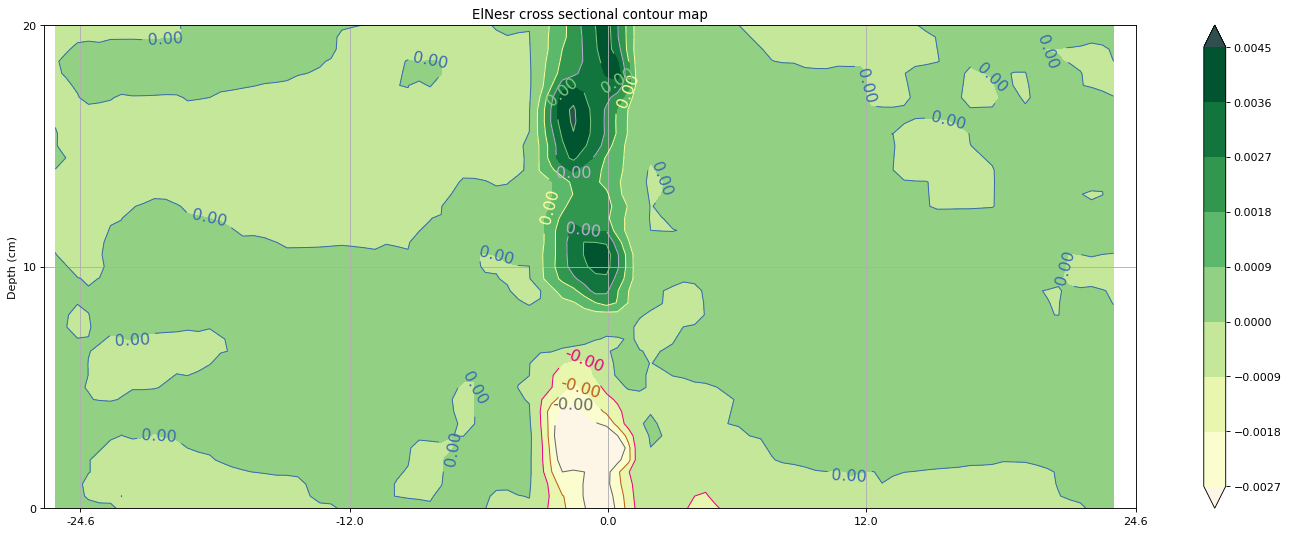

None

"For variable 'V3', the simulation's crosssection at '15.0 cm' of 'z' direction is:"

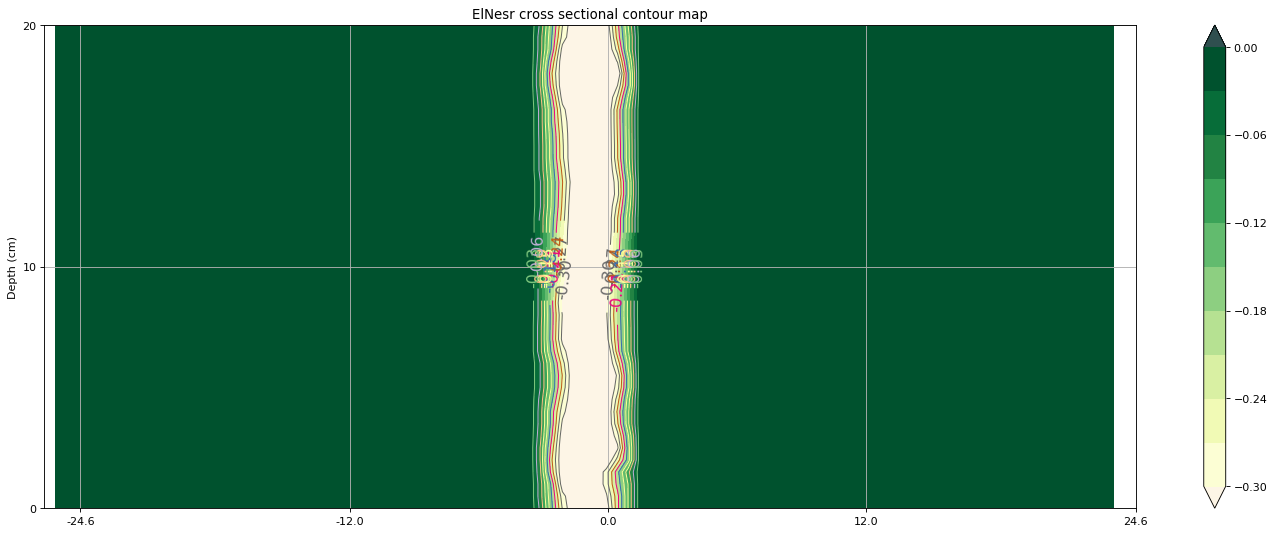

None

In [16]:
# testing draw_full_contour function
# variable = 2.3  # {Velocity z component}
time_step = 60
grid = 0.5  # cm
crosses = 15.  #cm0)]
tol = 10.
# section = 'y'
v_mask = {0: 'Th', 1: 'H', 2.1: 'V1', 2.2: 'V2', 2.3: 'V3'}
for section in ['y', 'x', 'z']:
    for variable in [0, 1, 2.1, 2.2, 2.3]:
        display(
            f"For variable '{v_mask[variable]}', the simulation's crosssection"
            f" at '{crosses} cm' of '{section}' direction is:")
        draw_full_contour(
            df,
            variable,
            time_step,
            grid,
            crosses,
            tol,
            section,
            return_arrays=False,
            x_step=12,
            z_step=10,
            mirror_x=True,
            mirror_z=False,
            fig_size=get_fig_shape(df, section))

### From Notebook 5

"For variable 'Th', the simulation's crosssection at '15.0 cm' of 'y' direction is:"

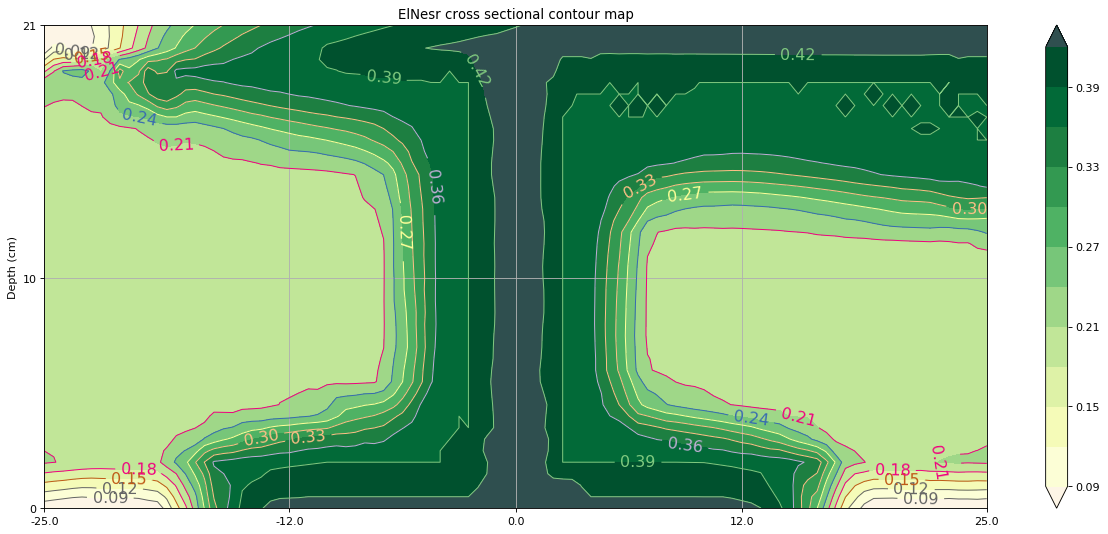

None

"For variable 'H', the simulation's crosssection at '15.0 cm' of 'y' direction is:"

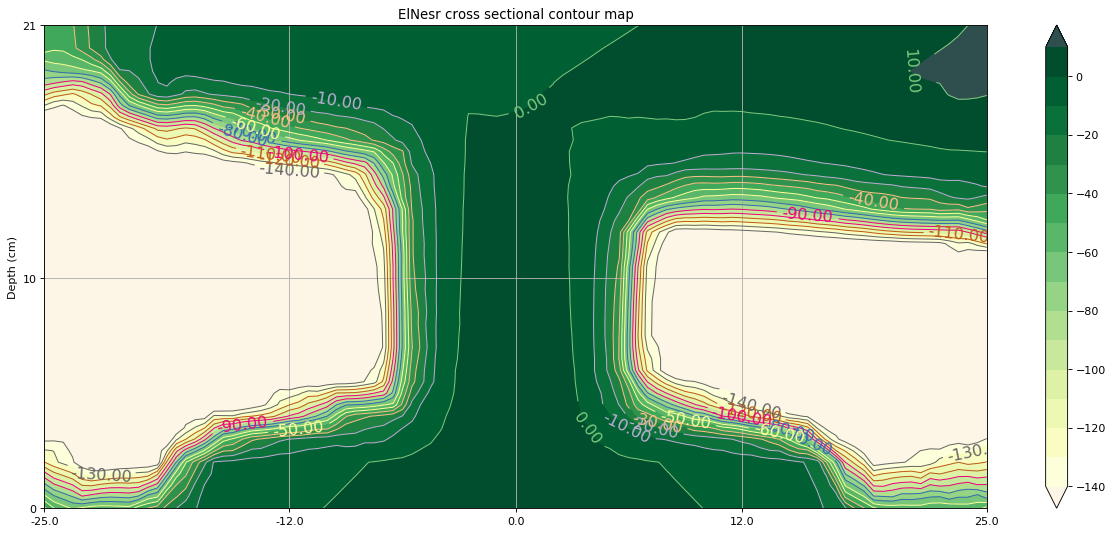

None

"For variable 'V1', the simulation's crosssection at '15.0 cm' of 'y' direction is:"

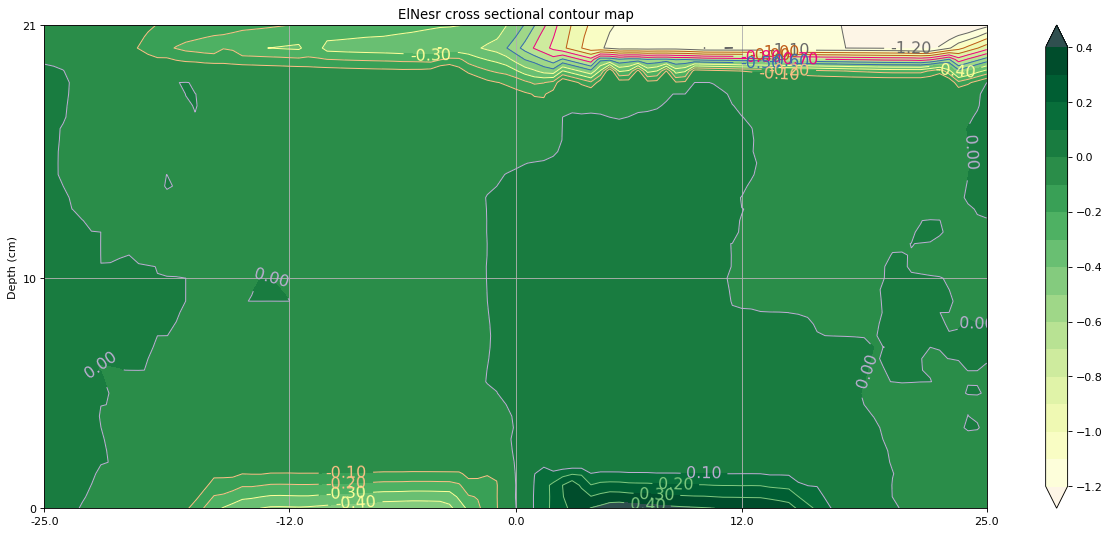

None

"For variable 'V2', the simulation's crosssection at '15.0 cm' of 'y' direction is:"

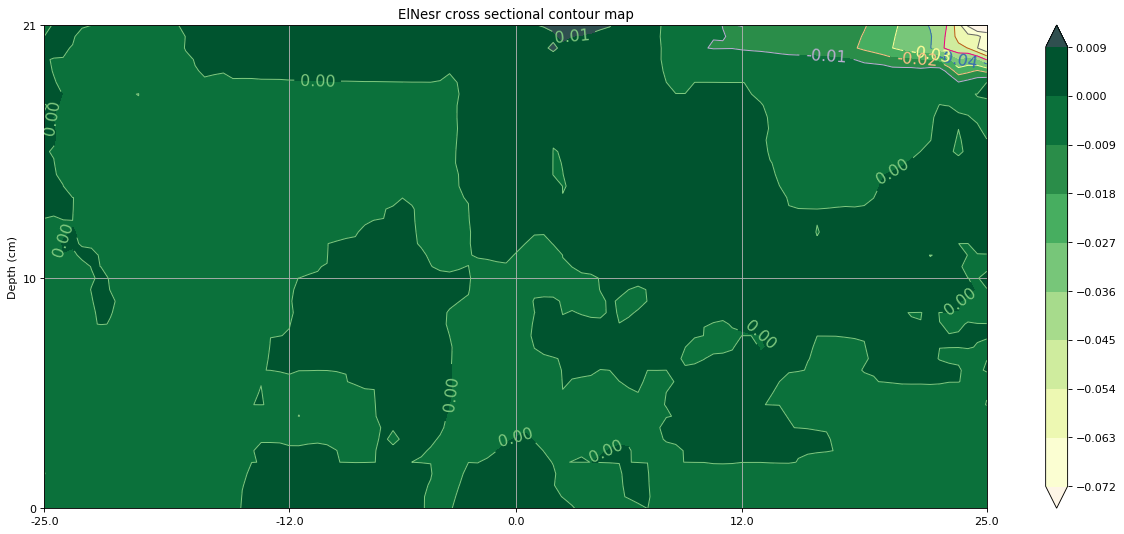

None

"For variable 'V3', the simulation's crosssection at '15.0 cm' of 'y' direction is:"

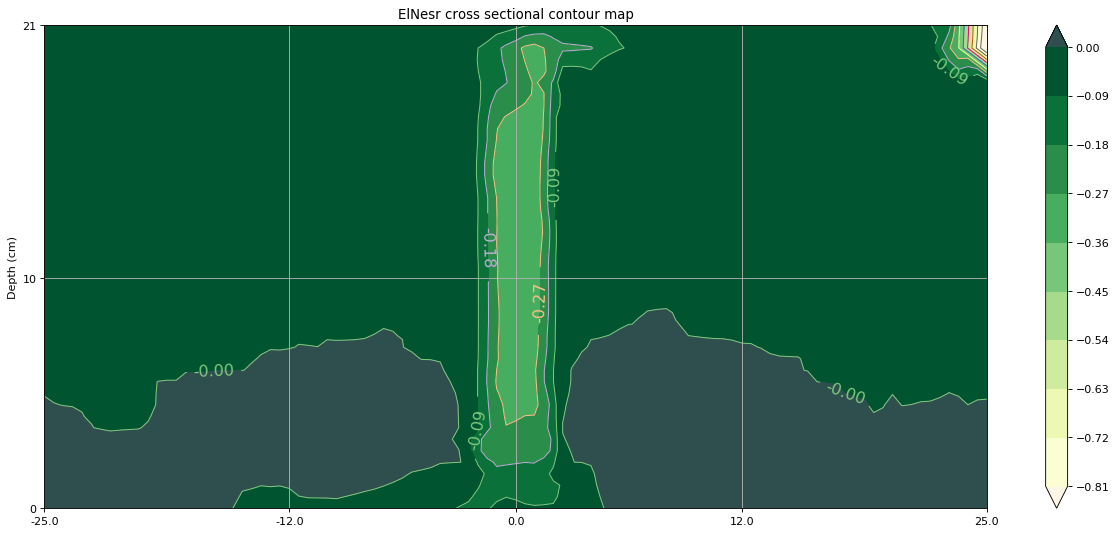

None

In [20]:
df_rotated = rotate_back(df,  2.2899, rotation_axis='y')
section = 'y'

for variable in [0, 1, 2.1, 2.2, 2.3]:
    display(
        f"For variable '{v_mask[variable]}', the simulation's crosssection"
        f" at '{crosses} cm' of '{section}' direction is:")
    draw_full_contour(
        df_rotated,
        variable,
        time_step,
        grid,
        crosses,
        tol,
        section,
        return_arrays=False,
        x_step=12,
        z_step=10,
        mirror_x=True,
        mirror_z=False,
        fig_size=get_fig_shape(df, section))